<a href="https://colab.research.google.com/github/sean-halpin/ml_tweepy_proj/blob/main/keras_dnn_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

Mounted at /content/drive/


In [27]:
import numpy as np
import pandas as pd
import re
import gensim
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [46]:
df = pd.read_csv("tweets_annotated.1646773409.csv")

In [47]:
df.head(2)

,tweet,sentiment
0,I want to know why the first round is branded ...,negative
1,"@DebbieW51726281 Hi there, this will be back o...",neutral


In [48]:
df.groupby('sentiment').nunique()

,tweet
sentiment,
negative,229
neutral,1361
positive,405


In [49]:
df.isnull().sum()

tweet        0
sentiment    0
dtype: int64

In [50]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [51]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),     deacc=True))

In [52]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [53]:
def labels_categorical(data):
  labels = np.array(data)
  y = []
  for i in range(len(labels)):
      if labels[i] == 'neutral':
          y.append(0)
      if labels[i] == 'negative':
          y.append(1)
      if labels[i] == 'positive':
          y.append(2)
  y = np.array(y)
  labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
  del y
  return labels

In [54]:
labels = labels_categorical(df.sentiment)

In [55]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.tweet)
sequences = tokenizer.texts_to_sequences(df.tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    1    2 1791]
 [   0    0    0 ...  181 1134  588]
 [   0    0    0 ...    1    2 1798]
 ...
 [   0    0    0 ...    1    2   25]
 [   0    0    0 ...   39   38   41]
 [   0    0    0 ...    1    2   27]]


In [56]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.3, random_state=32)

In [57]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
44/44 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.6736
Epoch 1: val_accuracy improved from -inf to 0.68500, saving model to best_model1.hdf5
44/44 [==============================] - 6s 93ms/step - loss: 0.8476 - accuracy: 0.6736 - val_loss: 0.5989 - val_accuracy: 0.6850
Epoch 2/70
44/44 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7614
Epoch 2: val_accuracy improved from 0.68500 to 0.82500, saving model to best_model1.hdf5
44/44 [==============================] - 3s 79ms/step - loss: 0.5720 - accuracy: 0.7614 - val_loss: 0.5178 - val_accuracy: 0.8250
Epoch 3/70
44/44 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8171
Epoch 3: val_accuracy improved from 0.82500 to 0.83000, saving model to best_model1.hdf5
44/44 [==============================] - 4s 82ms/step - loss: 0.4931 - accuracy: 0.8171 - val_loss: 0.4529 - val_accuracy: 0.8300
Epoch 4/70
44/44 [==============================] - ETA: 0s - lo

In [58]:
import keras

best_model = keras.models.load_model("best_model1.hdf5")

In [59]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

19/19 - 1s - loss: 0.4723 - accuracy: 0.8683 - 754ms/epoch - 40ms/step
Model accuracy:  0.8683333396911621


In [61]:
predictions = best_model.predict(X_test)

In [62]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


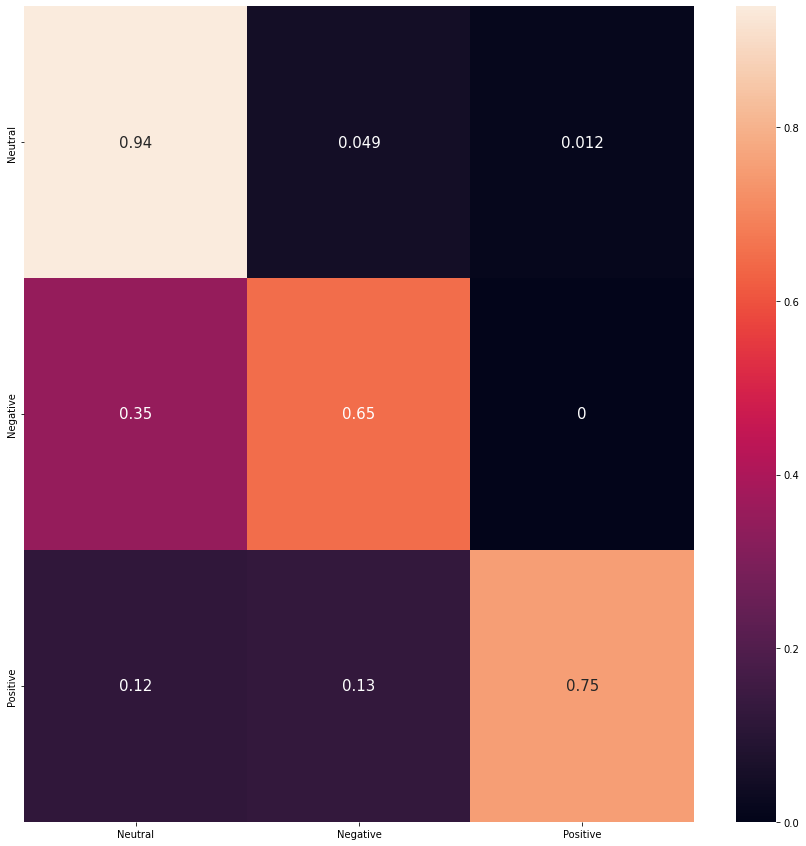

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt 
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [64]:
sentiment = ['Neutral','Negative','Positive']
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [65]:
# 'Negative'
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [66]:
# 'Positive'
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Neutral'

In [67]:
# 'Negative'
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'